In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import random
from scipy.stats import kurtosis, skew, iqr, norm, t, laplace, beta, multivariate_normal
from PIL import Image
import cv2
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D 
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 1) Сформувати тестову вибірку зображень з вихідного пакету

In [204]:
sampleSize = 250
myNumber = 9

sampleImages = []
allPixelBrightnessValues = []

# creating a sample of images of given sampleSize
while len(sampleImages) != sampleSize:
    randIndex = random.randint(myNumber, 25000)
    imageName = f'im{randIndex}.jpg'
    image = cv2.imread(f'./images/{imageName}')[:, :, 1] # reading only G-channels of RGB images
    sampleImages.append((imageName, image))

im9093.jpg


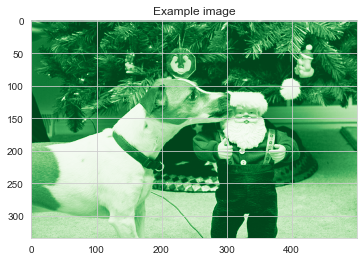

In [205]:
# example of sample image
print(sampleImages[0][0])
plt.title('Example image')
plt.imshow(sampleImages[0][1], cmap='Greens_r');

# 2) Для зеленого каналу кольору тестових зображень обчислити наступні характеристики розподілу значень яскравості пікселів:
 - Математичне очікування та дисперсію
 - Медіану та інтерквартильний розмах
 - Коефіцієнти асиметрії та ексцесу (нормалізований)
 - Гістограму значень яскравості пікселів (нормалізовану)

In [206]:
# creating an array of all green pixel brightness values of all images of our sample
for i in range(sampleSize):
    allPixelBrightnessValues.append(sampleImages[i][1].reshape(-1))
allPixelBrightnessValues = np.concatenate([img for img in allPixelBrightnessValues])

### Характеристики розподілу:

In [207]:
def distribution_characteristics(data):
    _mathExp = np.mean(data)
    _variance = np.var(data)
    _median = np.median(data)
    _iqr = iqr(data)
    _kurtosis = kurtosis(data.reshape(-1))
    _skew = skew(data.reshape(-1))
    return _mathExp, _variance, _median, _iqr, _kurtosis, _skew

In [208]:
# whole sample pixels characteristics
MathExp, Variance, Median, IQR, Kurtosis, Skewness = distribution_characteristics(allPixelBrightnessValues)
print("Distribution characteristics of all green pixels of sample:")
print("Math expectancy:", MathExp)
print("Variance:", Variance)
print("Median:", Median)
print("IQR:", IQR)
print("Kurtosis:", Kurtosis)
print("Skewness:", Skewness)

Distribution characteristics of all green pixels of sample:
Math expectancy: 105.03562867305908
Variance: 5517.800754215704
Median: 97.0
IQR: 126.0
Kurtosis: -1.0486518392975752
Skewness: 0.3099293903166746


In [209]:
# example image pixels characteristics
MathExp, Variance, Median, IQR, Kurtosis, Skewness = distribution_characteristics(sampleImages[0][1])
print("Distribution characteristics of green pixels of example image:")
print("Math expectancy:", MathExp)
print("Variance:", Variance)
print("Median:", Median)
print("IQR:", IQR)
print("Kurtosis:", Kurtosis)
print("Skewness:", Skewness)

Distribution characteristics of green pixels of example image:
Math expectancy: 96.32494011976048
Variance: 6604.006240265876
Median: 73.0
IQR: 156.0
Kurtosis: -1.2804433931168633
Skewness: 0.3948458116999965


### Гістограма значень яскравості пікселів (нормалізована):

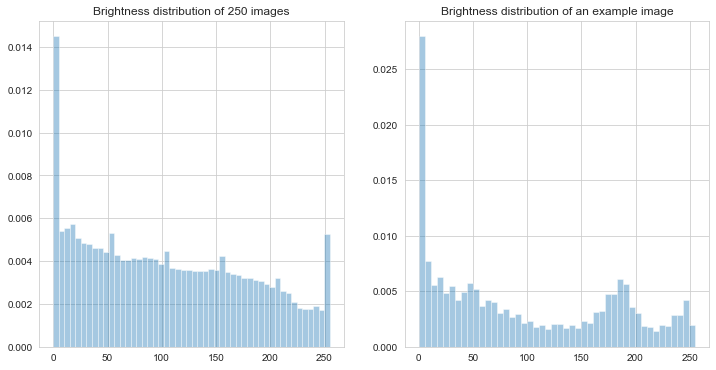

In [210]:
# plotting green pixels' brightness distribution of 250 sample images and of an example image
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('Brightness distribution of 250 images')
sns.distplot(allPixelBrightnessValues, kde=False, norm_hist = True);

plt.subplot(122)
plt.title('Brightness distribution of an example image')
sns.distplot(sampleImages[0][1], kde=False, norm_hist = True);

# 3) Провести обробку отриманих гістограм:
 - Провести апроксимацію гістограм з використанням імовірнісних розподілів:
     - Нормального (гаусового) розподілу
     - Розподілу Лапласа
     - Розподілу Стьюдента
     - Бета розподілу
 - Для кожної гістограми визначити найкращий тип апроксимуючого розподілу за критерієм мінімізації середньо квадратичного відхилення;
 - Побудувати розподіл отриманих апроксимацій за видом апроксимуючого розподілу;

## Провести апроксимацію гістограм з використанням імовірнісних розподілів:

In [211]:
def plot_hist(image, distributionName = None):
    f, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True);
    plt.figure(figsize=(12, 6));
    sns.distplot(image, kde=False, ax=axes[0], norm_hist = True);
    if distributionName == 'norm':
        sns.distplot(image, kde=False, fit=norm, ax=axes[1]);
    elif distributionName == 'laplace':
        sns.distplot(image, kde=False, fit=laplace, ax=axes[1]);
    elif distributionName == 'student':
        sns.distplot(image, kde=False,  fit=t, ax=axes[1]);
    elif distributionName == 'beta':
        sns.distplot(image, kde=False, fit=beta, ax=axes[1]);
    
    plt.show();

### Апроксимація нормального (гаусового) розподілу

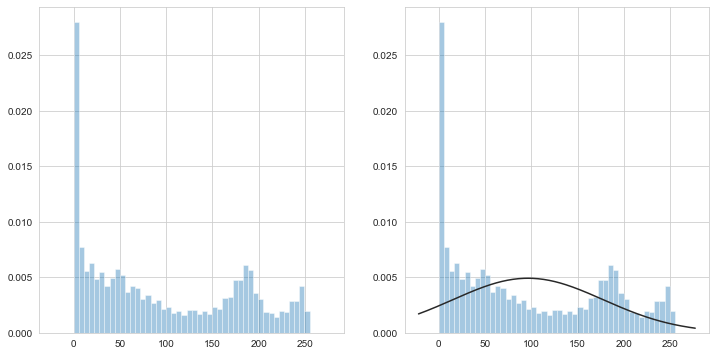

<Figure size 864x432 with 0 Axes>

In [212]:
plot_hist(sampleImages[0][1], 'norm');

### Апроксимація лапласового розподілу

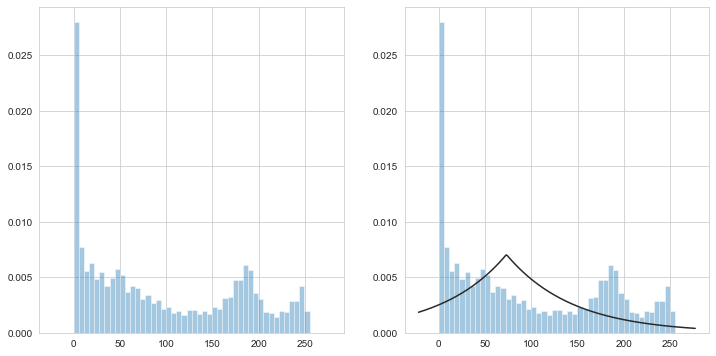

<Figure size 864x432 with 0 Axes>

In [213]:
plot_hist(sampleImages[0][1], 'laplace');

### Апроксимація розподілу стьюдента

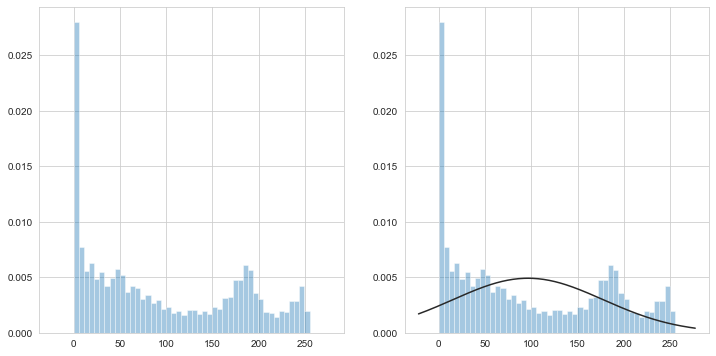

<Figure size 864x432 with 0 Axes>

In [214]:
plot_hist(sampleImages[0][1], 'student');

### Апроксимація бета-розподілу

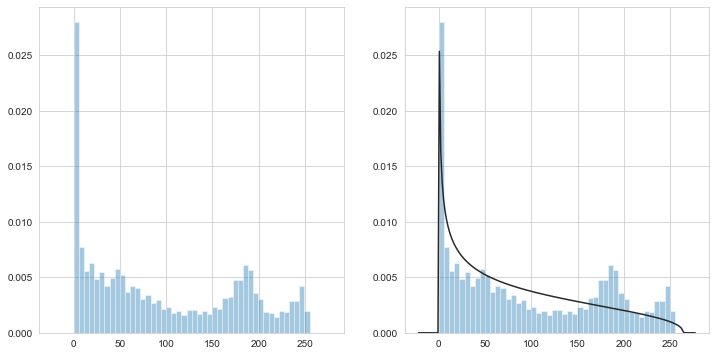

<Figure size 864x432 with 0 Axes>

In [215]:
plot_hist(sampleImages[0][1], 'beta');

## Для кожної гістограми визначити найкращий тип апроксимуючого розподілу за критерієм мінімізації середньо квадратичного відхилення:

In [216]:
def find_best_approximation(image):
    image = image.reshape(-1)
    bestDistribution = None
    minAvgSqrDeviation = 10**10
    
    # building array of normalized amounts of brightness values of all pixels of an image
    arr = []
    allPixelsCount = len(image)
    brightnessValuesCounts = Counter(image)
    
    for i in range(256):
        valueCount = brightnessValuesCounts[i]
        arr.append(valueCount / allPixelsCount)
        
    space = np.linspace(0,255,num=256)
    for dist in [norm, laplace, t, beta]:
        
        # approximate distribution to data
        params = dist.fit(image)

        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate approximated PDF
        pdf = dist.pdf(space, loc=loc, scale=scale, *arg)
        
        # Find average squared deviation of actual data and approximated PDF values
        avgSqrDeviation = np.sum(np.power(arr - pdf, 2.0))
            
        if avgSqrDeviation <= minAvgSqrDeviation:
            minAvgSqrDeviation = avgSqrDeviation
            bestDistribution = dist
            

    bestDistributionName = ''
    if(bestDistribution == norm):
        bestDistributionName = 'norm'
    elif(bestDistribution == t):
        bestDistributionName = 'student'
    elif(bestDistribution == laplace):
        bestDistributionName = 'laplace'
    elif(bestDistribution == beta):
        bestDistributionName = 'beta'
            
    return bestDistribution, minAvgSqrDeviation, bestDistributionName

In [217]:
def describe_image(image):
    MathExp, Variance, Median, IQR, Kurtosis, Skewness = distribution_characteristics(image)
    print("Math expectancy:", MathExp)
    print("Variance:", Variance)
    print("Median:", Median)
    print("IQR:", IQR)
    print("Kurtosis:", Kurtosis)
    print("Skewness:", Skewness)
    
    bestDistribution, avgSqrDeviation, bestDistributionName = find_best_approximation(image)
    print('Best approximation distribution type:', bestDistributionName)
    print('Squared error:', avgSqrDeviation)
    
    plot_hist(image, bestDistributionName)

122
im13678.jpg
Math expectancy: 111.76171733333334
Variance: 3395.4458667040994
Median: 100.0
IQR: 74.0
Kurtosis: -0.08509335130554252
Skewness: 0.6700722648703121
Best approximation distribution type: beta
Squared error: 0.0006830018057152328


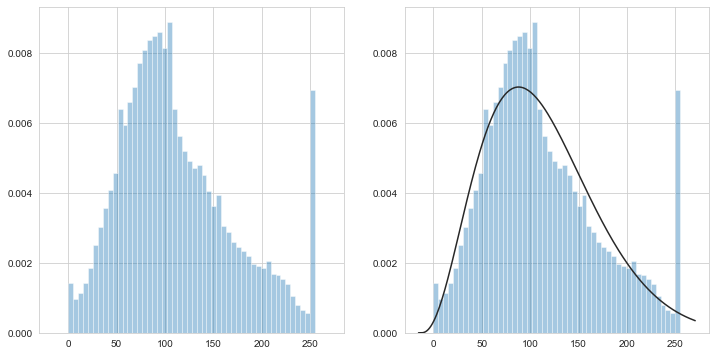

<Figure size 864x432 with 0 Axes>

138
im20880.jpg
Math expectancy: 118.36754736842106
Variance: 4819.378835247756
Median: 118.0
IQR: 122.0
Kurtosis: -1.1403138279741718
Skewness: -0.08060536917416532
Best approximation distribution type: student
Squared error: 0.0012605499990109468


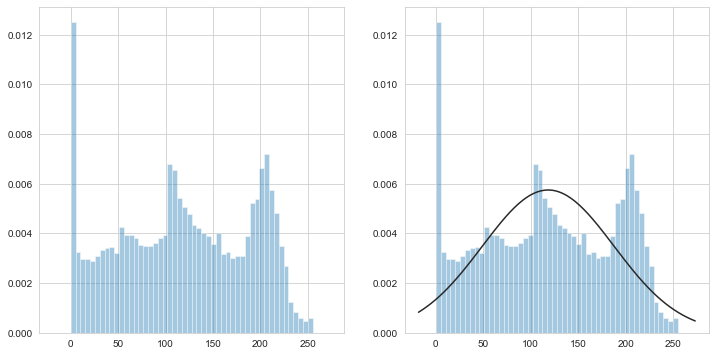

<Figure size 864x432 with 0 Axes>

194
im20030.jpg
Math expectancy: 85.43428828828829
Variance: 3457.096648937912
Median: 79.0
IQR: 105.0
Kurtosis: -0.6905168848454815
Skewness: 0.5056865794324458
Best approximation distribution type: beta
Squared error: 0.0029461754002156997


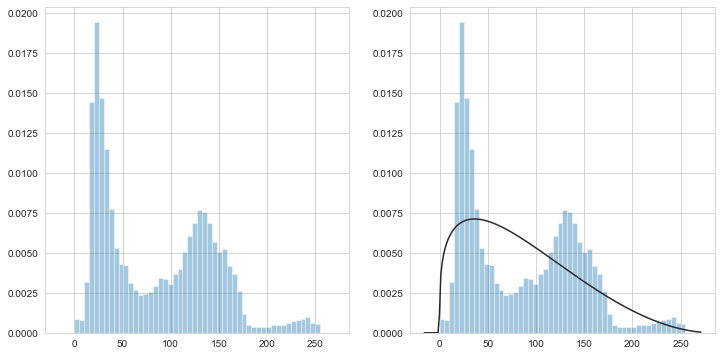

<Figure size 864x432 with 0 Axes>

In [218]:
# example
n_samples = 3
for index in np.random.choice(250, n_samples):
    print(index)
    print(sampleImages[index][0])
    describe_image(sampleImages[index][1])
    print('===================================================='*2)

## Побудувати розподіл отриманих апроксимацій за видом апроксимуючого розподілу

In [219]:
normalCount = 0
studentCount = 0
laplaceCount = 0
betaCount = 0

for i in tqdm(range(sampleSize), desc='Progress'):
    distName = find_best_approximation(sampleImages[i][1])[2]
    if(distName == 'norm'):
        normalCount+=1
    elif(distName == 'student'):
        studentCount+=1
    elif(distName == 'laplace'):
        laplaceCount+=1
    elif(distName == 'beta'):
        betaCount+=1

print('Розподіл отриманих апроксимацій:')
print('Нормальний розподіл:', normalCount, 'зображень')
print('Розподіл Стьюдента:', studentCount, 'зображень')
print('Розподіл Лапласа:', laplaceCount, 'зображень')
print('Бета-розподіл:', betaCount, 'зображень')

Progress: 100%|████████████████████████████████████████████████████████████████████| 250/250 [1:03:53<00:00, 15.33s/it]

Розподіл отриманих апроксимацій:
Нормальний розподіл: 27 зображень
Розподіл Стьюдента: 62 зображень
Розподіл Лапласа: 80 зображень
Бета-розподіл: 81 зображень


(array([27., 62., 80., 81.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5]),
 <a list of 4 Patch objects>)

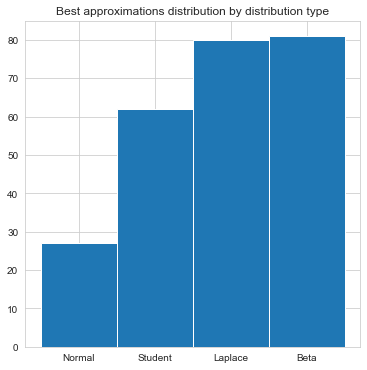

In [220]:
# plotting best approximations distribution
plt.figure(figsize=(6,6))
plt.title('Best approximations distribution by distribution type')
plt.hist(['Normal','Student','Laplace','Beta'], bins=np.arange(5)-0.5, weights = [normalCount, studentCount, laplaceCount, betaCount])

# Побудувати багатовимірні гаусові моделі
Сформувати вектори параметрів розподілу значень яскравості пікселів тестових зображень:
 - Математичне очікування
 - Математичне очікування та дисперсія
 - Математичне очікування, дисперсія та коефіцієнт асиметрії
 - Математичне очікування, дисперсія, коефіцієнти асиметрії та ексцесу

In [221]:
def group_statistics(data):
    math_exp_arr = []
    var_arr = []
    skew_arr = []
    kurt_arr = []
    for image in data:
        image_stats = distribution_characteristics(image[1])
        math_exp_arr.append(image_stats[0])
        var_arr.append(image_stats[1])
        skew_arr.append(image_stats[4])
        kurt_arr.append(image_stats[5])
    return math_exp_arr, var_arr, skew_arr, kurt_arr

In [222]:
math_exp, var, skew, kurt = group_statistics(sampleImages)

### Визначити параметри багатовимірних гаусових моделей для кожної групи векторів, відобразити їх графічно та у вигляді таблиць.

mean_vec:  104.87761442525847
cov_matrix: 
 1689.8425503228293


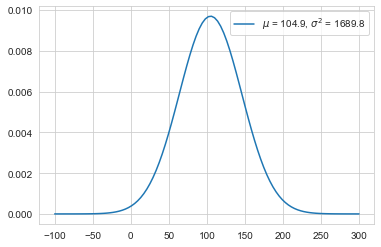

In [223]:
# 1. Math exp 
sample = math_exp
mean_vec_1 = np.mean(sample)
cov_matrix_1 = np.cov(sample)
print('mean_vec: ', mean_vec_1)
print('cov_matrix: \n', cov_matrix_1) 

x = np.linspace(start = -100, stop = 300, num = 100)
y = norm(mean_vec_1, np.sqrt(cov_matrix_1)).pdf(x)
plt.plot(x, y, label = '$\mu$ = {}, $\sigma^2$ = {}'.format(np.round(mean_vec_1, 1), np.round(cov_matrix_1, 1)))
plt.legend();

mean_vec:  104.87761442525847 3850.9124098370767
cov_matrix: 
 [[1.68984255e+03 1.02157907e+04]
 [1.02157907e+04 3.99049403e+06]]


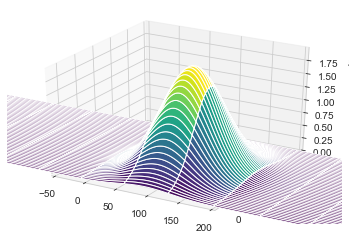

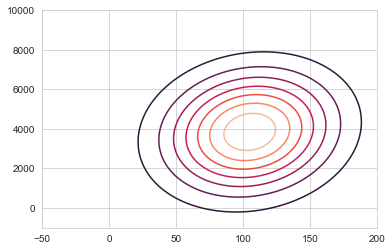

In [224]:
# 2. Math exp, Variance
sample = np.vstack((math_exp, var))
mean_vec_2 = np.mean(sample, axis=1)
cov_matrix_2 = np.cov(sample)
print('mean_vec: ', *mean_vec_2)
print('cov_matrix: \n', cov_matrix_2) 


x, y = np.mgrid[-500:3000, -1000:10000]
position = np.empty(x.shape + (2,))
position[:, :, 0] = x
position[:, :, 1] = y
z = multivariate_normal(mean_vec_2, cov_matrix_2).pdf(position)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlim(-50, 200)
ax.set_ylim(-1000, 10000)
ax.plot_surface(x, y, z, cmap='viridis')
plt.show()

plt.xlim(-50, 200)
plt.ylim(-1000, 10000)
plt.contour(x, y, z)
plt.show()

In [225]:
# 3. Math exp, Variance, Skew
sample = np.vstack((math_exp, var, skew))
mean_vec_3 = np.mean(sample, axis=1)
cov_matrix_3 = np.cov(sample)
print('mean_vec: ', *mean_vec_3)
print('cov_matrix: \n', cov_matrix_3) 

mean_vec:  104.87761442525847 3850.9124098370767 0.8825894164586362
cov_matrix: 
 [[ 1.68984255e+03  1.02157907e+04 -6.75992617e+01]
 [ 1.02157907e+04  3.99049403e+06 -3.96188388e+03]
 [-6.75992617e+01 -3.96188388e+03  3.46808507e+01]]


In [226]:
# 4. Math exp, Variance, Skew, Kurtosis
sample = np.vstack((math_exp, var, skew, kurt))
mean_vec_4 = np.mean(sample, axis=1)
cov_matrix_4 = np.cov(sample)
print('mean_vec: ', *mean_vec_4)
print('cov_matrix: \n', cov_matrix_4)               

mean_vec:  104.87761442525847 3850.9124098370767 0.8825894164586362 0.34993348178265865
cov_matrix: 
 [[ 1.68984255e+03  1.02157907e+04 -6.75992617e+01 -4.00854750e+01]
 [ 1.02157907e+04  3.99049403e+06 -3.96188388e+03 -1.89095272e+02]
 [-6.75992617e+01 -3.96188388e+03  3.46808507e+01  4.19781735e+00]
 [-4.00854750e+01 -1.89095272e+02  4.19781735e+00  1.43035071e+00]]
